In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=2a4ff120d86ceb51732d1e8b6d13363e599be92eacb5a4bbc7ca7e1531cdd3fb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=2c39cc53cf22c125fb907622149bbaff64e78c8714d1fc4623b4715f6cebe215
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 30.15 MiB/s, done.


# Import

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configuration

In [5]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [11]:
row = df.iloc[10]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

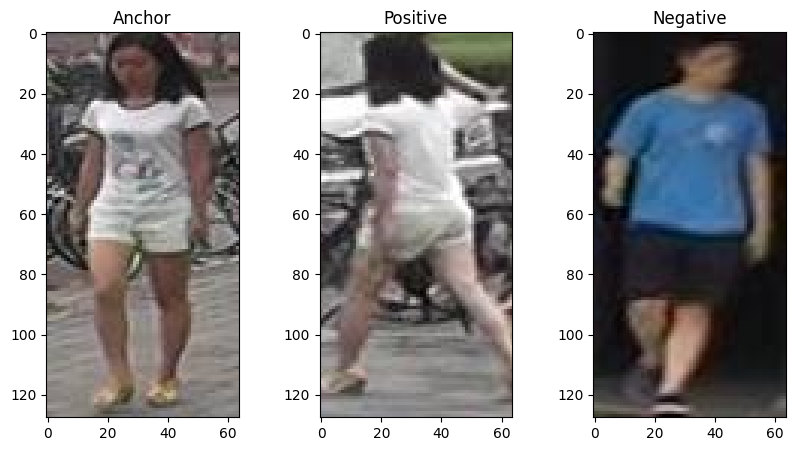

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [13]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# Create APN Dataset

In [14]:
class APN_Dataset(Dataset):

    def __init__(self, df):
      self.df = df

    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):
      row = self.df.iloc[idx]
      A_img = io.imread(DATA_DIR + row.Anchor)
      P_img = io.imread(DATA_DIR + row.Positive)
      N_img = io.imread(DATA_DIR + row.Negative)

      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
      P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

      return A_img, P_img, N_img


In [15]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


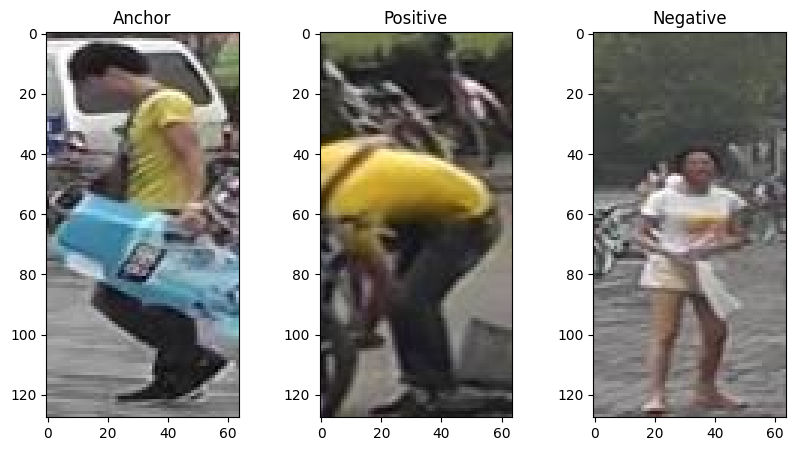

In [16]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset in to Batches

In [17]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [18]:
print(f'No. of batches in trainloader: {len(trainloader)}')
print(f'No. of batches in validloader: {len(validloader)}')

No. of batches in trainloader: 100
No. of batches in validloader: 25


In [19]:
for A, P, N in trainloader:
  break;

print(f'One image batch shape: {A.shape}')

One image batch shape: torch.Size([32, 3, 128, 64])


# Create Model

In [45]:
class APN_Model(nn.Module):

    def __init__(self, emb_size = 512):
      super(APN_Model, self).__init__()

      self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
      self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features=emb_size)

    def forward(self, images):

      embeddings = self.efficientnet(images)

      return embeddings

In [46]:
model = APN_Model()
model.to(DEVICE);

# Create train and eval function

In [47]:
def train_fn(model, dataloader, optimizer, criterion):

    model.train() # On Dropout
    total_loss = 0.0

    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [48]:
def eval_fn(model, dataloader, criterion):

    model.eval() # OFF Dropout
    total_loss = 0.0

    with torch.no_grad():
      for A, P, N in tqdm(dataloader):

        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)


        total_loss += loss.item()

      return total_loss / len(dataloader)

In [43]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create training loop

In [49]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss:
      torch.save(model.state_dict(), 'best_model.pt')
      best_valid_loss = valid_loss
      print('SAVED_WEIGHTS_SUCCESS!!')

    print(f'Epochs: {i+1} train loss: {train_loss} validloss: {valid_loss}')

100%|██████████| 25/25 [00:02<00:00, 11.17it/s]


SAVED_WEIGHTS_SUCCESS!!
Epochs: 1 train loss: 0.942149099111557 validloss: 1.0122419261932374


100%|██████████| 25/25 [00:02<00:00, 10.06it/s]


Epochs: 2 train loss: 0.9539426273107529 validloss: 1.0245441007614136


100%|██████████| 25/25 [00:03<00:00,  7.61it/s]


Epochs: 3 train loss: 0.9563887190818786 validloss: 1.0160610914230346


100%|██████████| 25/25 [00:02<00:00, 11.45it/s]


Epochs: 4 train loss: 0.9601440280675888 validloss: 1.0182789468765259


100%|██████████| 25/25 [00:04<00:00,  5.38it/s]


Epochs: 5 train loss: 0.9514019411802291 validloss: 1.0142300462722778


100%|██████████| 25/25 [00:04<00:00,  6.16it/s]


Epochs: 6 train loss: 0.9496533977985382 validloss: 1.0313129138946533


100%|██████████| 25/25 [00:04<00:00,  6.09it/s]


Epochs: 7 train loss: 0.9523175966739654 validloss: 1.0246556115150451


100%|██████████| 25/25 [00:02<00:00,  9.43it/s]


Epochs: 8 train loss: 0.9500508058071137 validloss: 1.0210324048995971


100%|██████████| 25/25 [00:03<00:00,  7.83it/s]


Epochs: 9 train loss: 0.9412071728706359 validloss: 1.0315484094619751


100%|██████████| 25/25 [00:03<00:00,  8.14it/s]


SAVED_WEIGHTS_SUCCESS!!
Epochs: 10 train loss: 0.9416671216487884 validloss: 1.011790382862091


100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Epochs: 11 train loss: 0.9596285057067871 validloss: 1.0166783022880554


100%|██████████| 25/25 [00:04<00:00,  5.84it/s]


SAVED_WEIGHTS_SUCCESS!!
Epochs: 12 train loss: 0.9427955585718155 validloss: 1.0116815304756164


100%|██████████| 25/25 [00:02<00:00,  9.56it/s]


Epochs: 13 train loss: 0.9439450216293335 validloss: 1.040965120792389


100%|██████████| 25/25 [00:03<00:00,  8.13it/s]


Epochs: 14 train loss: 0.9528689187765121 validloss: 1.013792507648468


100%|██████████| 25/25 [00:02<00:00, 10.92it/s]

Epochs: 15 train loss: 0.9501973897218704 validloss: 1.014885675907135


# Get Anchor Embeddings

In [53]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
          A = io.imread(DATA_DIR + i)
          A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
          A = A.to(DEVICE)
          A_enc = model(A.unsqueeze(0)) # (c, h, w) => (bs=1, c, h , w)
          encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [54]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:54<00:00, 73.42it/s] 


In [55]:
df_enc.to_csv('database.csv', index =False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.225592,0.274813,0.019458,0.066229,0.146970,-0.371556,-0.073348,0.895269,-0.298346,...,0.180721,0.061023,0.097242,-0.331849,-0.138286,0.145843,0.182384,-0.113768,0.163005,-0.047992
1,1420_c3s3_061978_03.jpg,0.222436,0.345427,0.092081,0.155657,0.312914,0.077357,-0.296809,0.374089,0.043938,...,0.347832,0.361905,0.025933,0.090036,0.158517,-0.080061,-0.112429,0.034542,0.214655,-0.248138
2,1420_c5s3_062565_05.jpg,0.241606,0.460576,-0.230238,0.105944,0.212905,0.069500,0.246980,0.422573,-0.262892,...,0.066112,-0.047055,-0.283802,-0.079330,-0.064162,0.102040,-0.090273,0.141363,-0.041059,0.055157
3,1420_c6s3_085592_04.jpg,0.352596,0.382901,0.143351,-0.335253,0.254285,0.580914,-0.139974,-0.053467,0.235225,...,-0.056417,-0.213480,0.098902,-0.382967,0.323394,-0.513761,-0.437876,-0.351364,-0.108319,0.154202
4,0663_c5s3_085987_03.jpg,0.561367,-0.047278,-0.189942,-0.680738,-0.535238,0.342208,0.097437,0.165942,-0.203760,...,-0.055628,-0.250411,-0.501658,0.131919,-0.162477,0.607693,-0.461265,-0.488631,0.571499,0.048761


# Inference

In [57]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [66]:
idx =5
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [67]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [68]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i: i+1, :])
    distance = np.append(distance, dist)

In [69]:
closest_idx = np.argsort(distance)

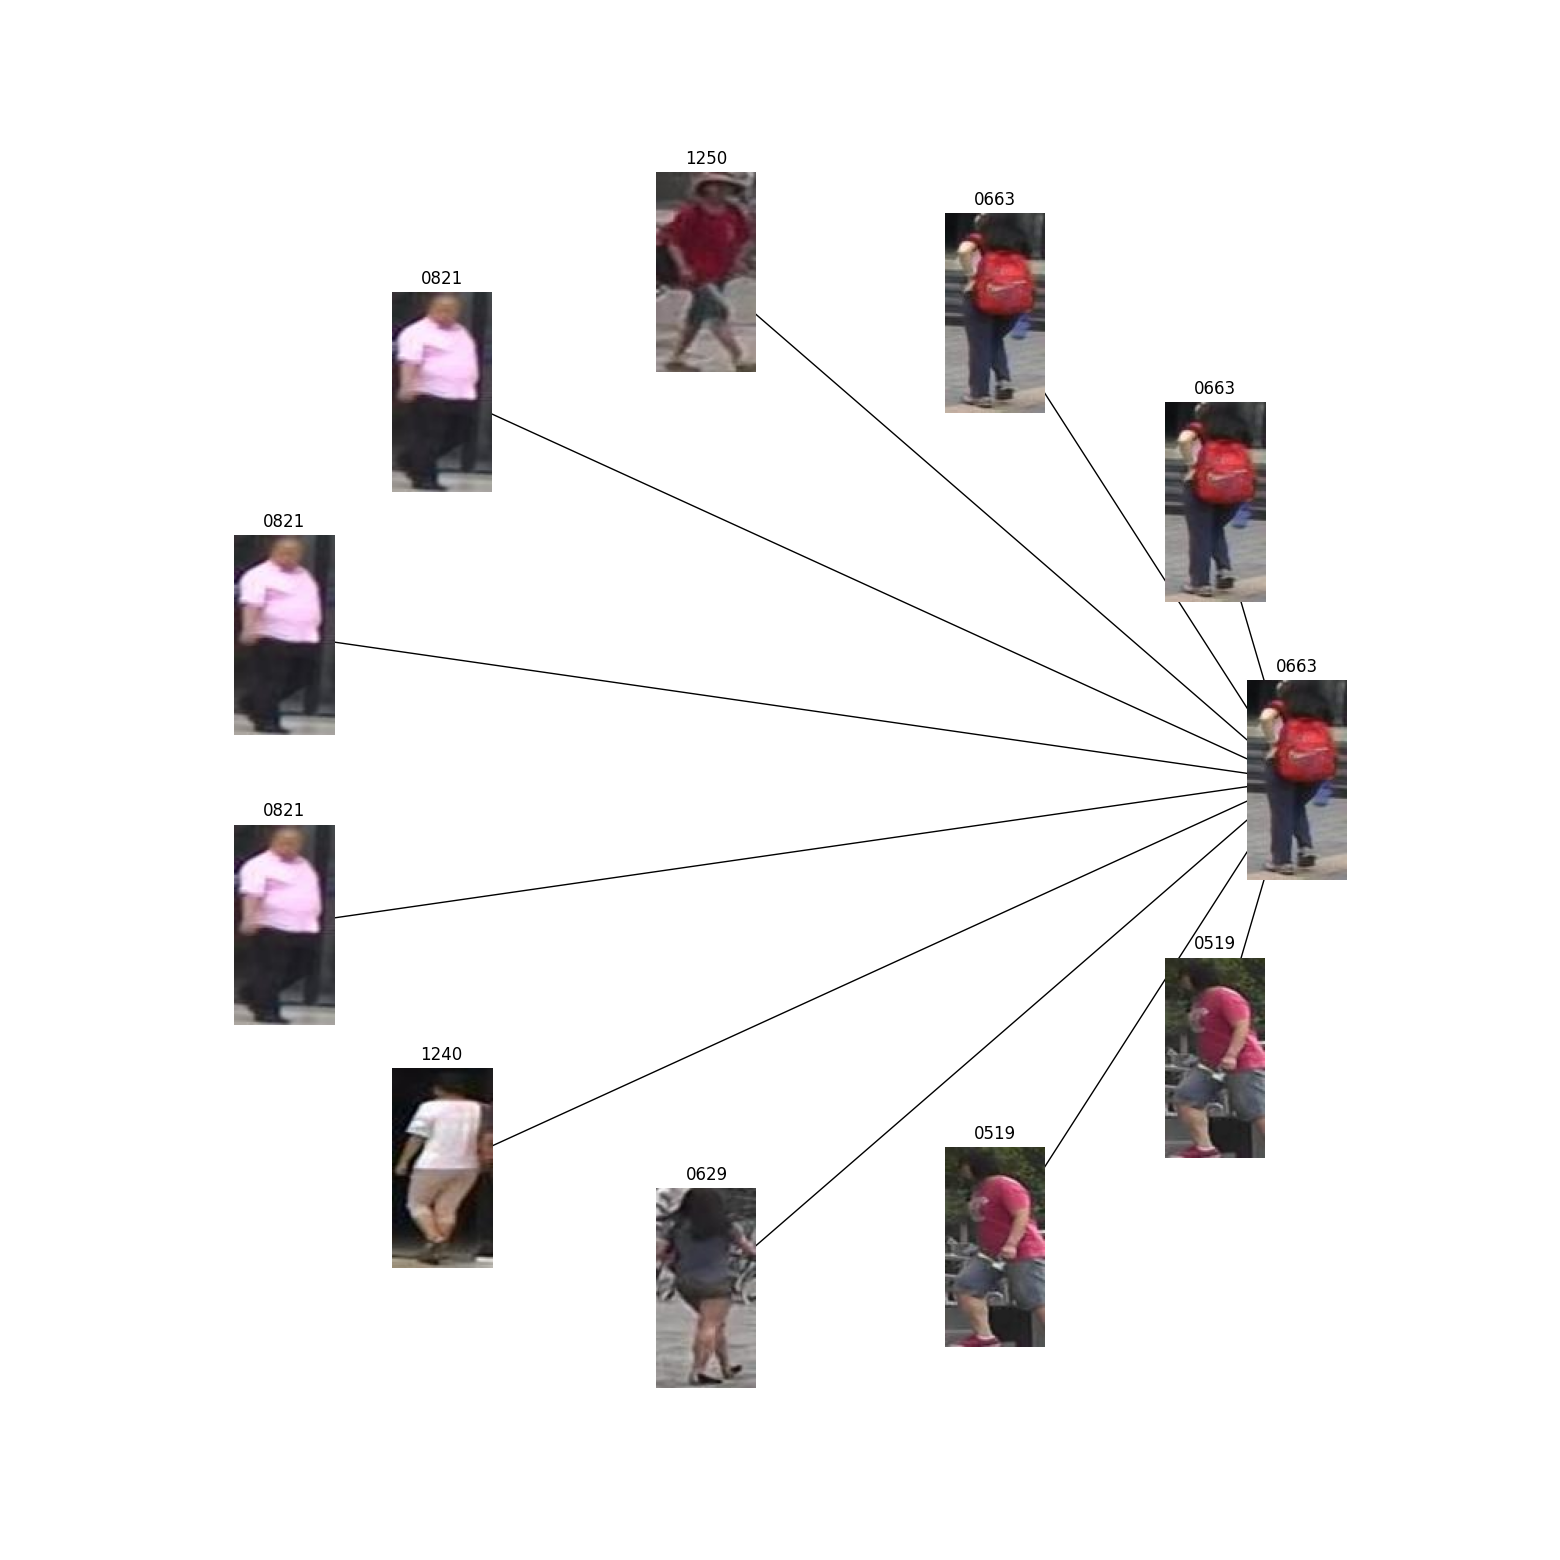

In [70]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);